![Hacker news](https://miro.medium.com/max/980/1*Odj6BW8rfq-gExKp_rJrdA.png)




#  Hacker news

Hacker News is a social news website focusing on computer science and entrepreneurship. It is run by Paul Graham's investment fund and startup incubator, Y Combinator. In general, content that can be submitted is defined as "anything that gratifies one's intellectual curiosity"[[1](https://en.wikipedia.org/wiki/Hacker_News)]

# Y Combinator
Y Combinator is an American seed accelerator, started in March 2005. Y Combinator has launched various successful companies and there are total of 1058 active companies in [YCList](http://yclist.com/) website.

This kernel attempts to answer some of questions stated in Hacker news [dataset](https://www.kaggle.com/hacker-news/hacker-news) inspirations section. This kernel heavily uses code samples from [Mentions of Kaggle on Hacker News](https://www.kaggle.com/mrisdal/mentions-of-kaggle-on-hacker-news) and [SQL Scavenger Hunt Handbook](https://www.kaggle.com/rtatman/sql-scavenger-hunt-handbook) kernels.

Table of contents

1. Hacker News scoring
1. Top users of all time
1. Is the community biased  towards Y Combinator startups?
1. Stories of major companies over the year
1.  YC Exited VS Dead
1. Which YC companies are scoring more points?
1. What is in Hacker News stories?


Lets import the necessary modules we will be using pandas, bigquery bq_helper numpy wordcloud pyplot from matplotlib and spacy for named entity recognition. 

In [1]:
from google.cloud import bigquery
import pandas as pd
import bq_helper 
import numpy as np
%matplotlib inline
from wordcloud import WordCloud
import matplotlib.pyplot as plt

import spacy
nlp = spacy.load('en')

# create a helper object for our bigquery dataset
hacker_news = bq_helper.BigQueryHelper(active_project= "bigquery-public-data", 
                                       dataset_name = "hacker_news")

client = bigquery.Client()

%matplotlib inline

Using Kaggle's public dataset BigQuery integration.
Using Kaggle's public dataset BigQuery integration.


In order to see how stories table looks like we can call the head method of variable `hacker_news` which was initialized above and pass the name of table. We will be using stories table to access story title time_ts score author decendent. This function is mentioned in the kernels [Mentions of Kaggle on Hacker News](https://www.kaggle.com/mrisdal/mentions-of-kaggle-on-hacker-news) and [SQL Scavenger Hunt Handbook](https://www.kaggle.com/rtatman/sql-scavenger-hunt-handbook).

In [2]:
hacker_news.head("stories")

,id,by,score,time,time_ts,title,url,text,deleted,dead,descendants,author
0,6940813,sarath237,0,1387536270,2013-12-20 10:44:30+00:00,Sheryl Brindo Hot Pics,http://www.youtube.com/watch?v=ym1cyxneB0Y,Sheryl Brindo Hot Pics,None,True,NaN,sarath237
1,6991401,123123321321,0,1388508751,2013-12-31 16:52:31+00:00,Are you people also put off by the culture of ...,,They&#x27;re pretty explicitly &#x27;startup f...,None,True,NaN,123123321321
2,1531556,ssn,0,1279617234,2010-07-20 09:13:54+00:00,New UI for Google Image Search,http://googlesystem.blogspot.com/2010/07/googl...,Again following on Bing's lead.,None,None,0.0,ssn
3,5012398,hoju,0,1357387877,2013-01-05 12:11:17+00:00,Historic website screenshots,http://webscraping.com/blog/Generate-website-s...,Python script to generate historic screenshots...,None,None,0.0,hoju
4,7214182,kogir,0,1401561740,2014-05-31 18:42:20+00:00,Placeholder,,Mind the gap.,None,None,0.0,kogir


# Hacker News scoring

For someone new scoring of stories might be new concept. In order to see `min`, `max` and `avg` score of all the stories in stories table we will call `MIN`, `MAX` and `AVG`. This is just to check the scoring criteria and see how much scoring is good scoring for any story in hacker news. If you want to know more about the standard functions which we can use in SQL queries check out this [link](https://cloud.google.com/bigquery/docs/reference/standard-sql/functions-and-operators#min).

In [3]:
## So we will declare the query variable
## we will be using same name for queries in entire notebook hope this doesnt create confusion
query = """
SELECT MIN(score) as min_score, MAX(score) as max_score, AVG(score) as avg_score
FROM `bigquery-public-data.hacker_news.stories`
"""
hacker_news.estimate_query_size(query)

0.01371852308511734

Function `estimate_query_size`estimates the size of data which will be processed. The value returned is in gigabytes. This means when user will execute this query approximately 0.013 Gb of data will be processed.

In [4]:
query_job = client.query(query)
iterator = query_job.result(timeout=30)
rows = list(iterator)

After executing code segment above, `row` variable will contain the the data we need to carry out analysis.

In [5]:
# Transform the rows into a nice pandas dataframe
unique_scores = pd.DataFrame(data=[list(x.values()) for x in rows], columns=list(rows[0].keys()))
unique_scores.fillna(0, inplace=True)
# Look at the first 10 top scores
unique_scores.head()

,min_score,max_score,avg_score
0,0,4339,10.335148


Above code section access the data from `row` variable and pass it in pandas dataframe which is very useful to make plots and do basic operations. Notice i renamed my columns to `min_score`,`max_score` and `avg_score`. Renaming columns is always best idea when you apply functions on column data. So after seeing the output we can see the row with renamed attributes.

Data suggests that
**Stories with more than 4 thousand score can be considered as Viral or top story in hacker news.**


This was simple walkthrough of process which i will be using in rest of notebook. I will mention new things added to these basic steps in order to make it clear and possibly give links if one want to read more code samples.


# Top users of all time

In this section we will access and plot the stories data of authors with top scores and order the record by decending order of `total_score`. Please note that writing `LIMIT 30` might have limited the output to 30 rows but this doesnt limit the total data being processed. This is nice adviced given by Rachael in her notebook [SQL Scavenger Hunt Handbook](https://www.kaggle.com/rtatman/sql-scavenger-hunt-handbook).

Here in out SQL query we are grouping the stories using `authors` column data and calculating total stories by calling funtion `COUNT(id)` where id is unique identifier of stories rows. Then we are ordering the rows by `total_score` column which is alias for `SUM(score)`.

In [6]:
query = """
SELECT 
SUM(score) as total_score, author,
SUM(descendants) as total_decendants,
count(id) as total_stories
FROM `bigquery-public-data.hacker_news.stories`
GROUP BY author
ORDER BY total_score DESC
LIMIT 30
"""
hacker_news.estimate_query_size(query)

0.05897093191742897

In [7]:
query_job = client.query(query)
iterator = query_job.result(timeout=30)
rows = list(iterator)

Text(0, 0.5, 'Score')

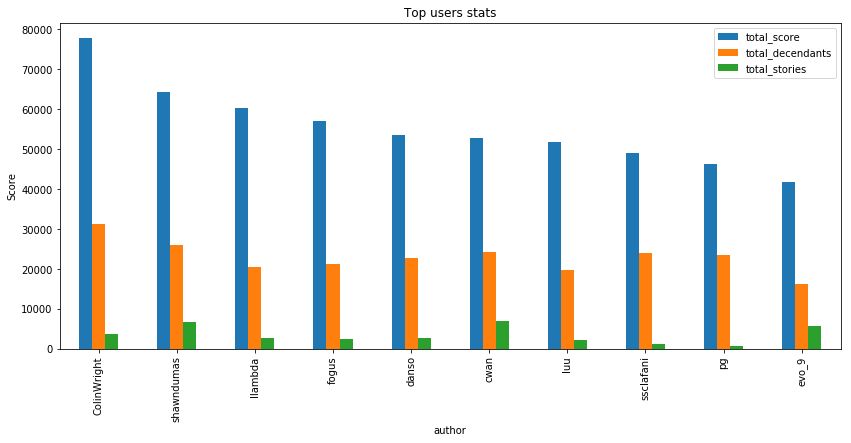

In [8]:
# Transform the rows into a nice pandas dataframe
top_users = pd.DataFrame(data=[list(x.values()) for x in rows], columns=list(rows[0].keys()))
top_users.fillna(0, inplace=True)
# Look at the first 10 top scores
top_users.sort_values("total_score")[::-1][:10].plot(x="author",y=["total_score", "total_decendants", "total_stories"], 
                                                   kind="bar",figsize=(14,6),
                                                   title='Top users stats').set_ylabel("Score")

In above cell I have filed the NaN value with 0 and sorted the table using renamed column name `top_score`. After this we can directly plot the bar graph. Here i have limited the plot to 10 rows only this can be extended to 30.

For sake of comparison lets see how many total stories are there in Hacker news.

In [9]:
query = """
SELECT 
COUNT(*) as total_stories
FROM `bigquery-public-data.hacker_news.stories`
"""
hacker_news.estimate_query_size(query)

0.0

In [10]:
query_job = client.query(query)

iterator = query_job.result(timeout=30)
rows = list(iterator)

In [11]:
count = pd.DataFrame(data=[list(x.values()) for x in rows], columns=list(rows[0].keys()))

In [12]:
print("Total number of stories {}".format(count.total_stories.values[0]))

Total number of stories 1959809


Now there might be some authors who have authored many stories but coudnt get enough scores. Lets see users with most stories,  here we wil just change `ORDER BY total_stories DESC` and we will get users will most stories.

In [13]:
query = """
SELECT 
SUM(score) as total_score, author,
SUM(descendants) as total_decendants,
count(id) as total_stories
FROM `bigquery-public-data.hacker_news.stories`
WHERE author IS NOT NULL
GROUP BY author
ORDER BY total_stories DESC
LIMIT 30
"""
hacker_news.estimate_query_size(query)

0.05897093191742897

In [14]:
query_job = client.query(query)
iterator = query_job.result(timeout=30)
rows = list(iterator)

In [15]:
# Transform the rows into a nice pandas dataframe
most_freq_users = pd.DataFrame(data=[list(x.values()) for x in rows], columns=list(rows[0].keys()))

Text(0, 0.5, 'Score')

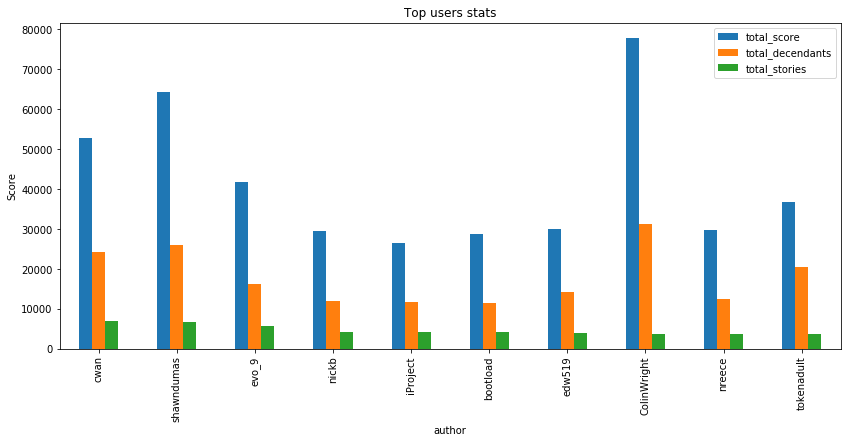

In [16]:
# Look at the first 10 top scores
most_freq_users.sort_values("total_stories")[::-1][:10].plot(x="author",y=["total_score", "total_decendants", "total_stories"], 
                                                   kind="bar",figsize=(14,6),
                                                   title='Top users stats').set_ylabel("Score")

In [17]:
print("Total number of stories {} posted by 30 most active users".format(most_freq_users.total_stories.sum()))

Total number of stories 95671 posted by 30 most active users


In [18]:
print("Percentage stories posted by 30 most active users : {}%".format(most_freq_users.total_stories.sum()*100/count.total_stories.values[0]))

Percentage stories posted by 30 most active users : 4.8816491811191804%


It is very interesting to see nearly 5% of total stories in Hacker News are authored by just 30 people. So is it dominated by handful of people? I would say no to this answer.

# Is the community biased  towards Y Combinator startups?

Well that's even tougher question to answer. But we will start by trying to find the score of the top stories in which "Y combinator" is mentioned. Then we will compare it with the average scores of stories in which  "Hacker news" isnt mentioned. Here we are assuming the startup launched by YCombinator mentions "Y combinator" in title of story.

So if the average score of those stories are way above the average score of other stories then we can say that the community is biased towards Y Combinator stories or in other words community likes stories of  Y Combinator more as compared to other stories.

Here in SQL query we will use `REGEXP_CONTAINS` function which we use as conditional in order to match our given regular expression. For more detail on this function you can visit  [here](https://cloud.google.com/bigquery/docs/reference/standard-sql/functions-and-operators#regexp_contains).

In [19]:
# Writing query string for our specific need here
query = """
SELECT score, title
FROM `bigquery-public-data.hacker_news.stories`
WHERE REGEXP_CONTAINS(title, r"Y Combinator|YCombinator")
ORDER BY score  DESC
"""

hacker_news.estimate_query_size(query)

0.09599658381193876

In [20]:
query_job = client.query(query)
iterator = query_job.result(timeout=30)
HNrows = list(iterator)

Text(0, 0.5, 'Score')

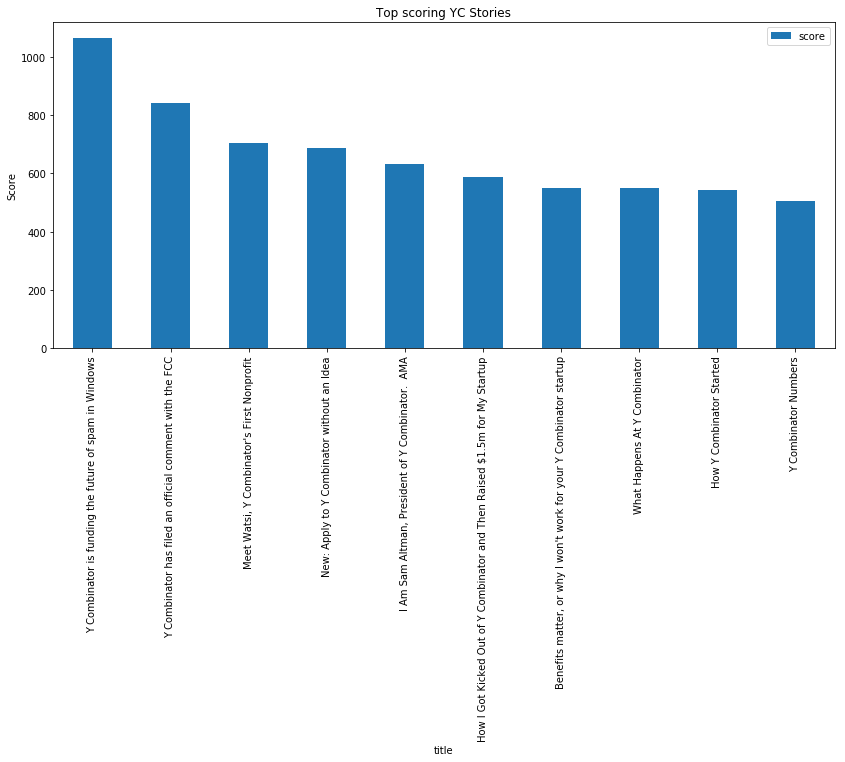

In [21]:
# Transform the rows into a nice pandas dataframe
HN_scores = pd.DataFrame(data=[list(x.values()) for x in HNrows], columns=list(HNrows[0].keys()))
HN_scores.sort_values("score")[::-1][:10].plot(x="title",y=["score"], 
                                                   kind="bar",figsize=(14,6),
                                                   title='Top scoring YC Stories').set_ylabel("Score")

In [22]:
print("Total number of stories with mention of YC {}".format(len(HN_scores)))

Total number of stories with mention of YC 3117


In [23]:
print("Avg score of stories with mention of YC {}".format(HN_scores.score.mean()))

Avg score of stories with mention of YC 19.32820019249278


For sake of comparison lets check the average score of stories which dont mention Hacker news. 

In order to select those rows which dont mention Hacker news we will use `NOT IN`operator and use nested SQL statement to select `id`column values of those stories which mention Hacker news in title.

In [24]:
# Writing query string for our specific need here
query = """
SELECT AVG(score) as avg_score
FROM `bigquery-public-data.hacker_news.stories`
WHERE id NOT IN (SELECT id FROM `bigquery-public-data.hacker_news.stories` WHERE REGEXP_CONTAINS(title, r"Y Combinator|YCombinator")) 
"""

hacker_news.estimate_query_size(query)

0.11059829872101545

In [25]:
query_job = client.query(query)
iterator = query_job.result(timeout=30)
Non_HN_score = list(iterator)

In [26]:
Non_HN_df = pd.DataFrame(data=[list(x.values()) for x in Non_HN_score], columns=list(Non_HN_score[0].keys()))
print("Total average score of stories without mention of HN {}".format(Non_HN_df.avg_score.values[0]))

Total average score of stories without mention of HN 10.319897919214553


There is not much difference in scores so it is safe to assume the users giving scores arent biased at all. This supports the fact that the quality of content determines score.

# Stories of major companies over the year


In this section we will analyze stories of few startup companies like Uber HP Tesla Yahoo and facebook. We know the successes and failure of these companies and we will use that to our advantage to form our speculations if the coverage of companies decide the success of a companies.

Here in SQL query we are using same `REGEXP_CONTAINS` function used previously and find stories with title having name of companies. We are using this simple method with one SQL command for one company for now, later in this notebook we will use one single regular expression to find title which conain name of all companies this can further save the data needed to be processed. For that we will need to process data later.

In [27]:
query ="""
SELECT count(*) as total_stories, SUM(score) as total_score,
EXTRACT(YEAR FROM time_ts) AS year
FROM `bigquery-public-data.hacker_news.stories`
WHERE REGEXP_CONTAINS(title, r"(U|u)ber")
GROUP BY year
ORDER BY year
"""

hacker_news.estimate_query_size(query)

0.11040666233748198

In [28]:
query_job = client.query(query)
iterator = query_job.result(timeout=30)
uber_stories_per_year = list(iterator)

Text(0, 0.5, 'Score')

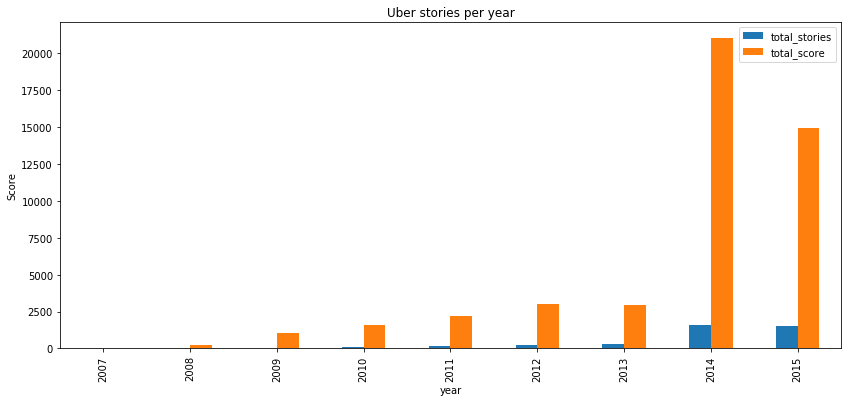

In [29]:
uber_stories_df = pd.DataFrame(data=[list(x.values()) for x in uber_stories_per_year], columns=list(uber_stories_per_year[0].keys()))
uber_stories_df.plot(x="year",y=["total_stories","total_score"],
                     kind="bar",figsize=(14,6),
                     title='Uber stories per year').set_ylabel("Score")

In [30]:

query ="""
SELECT count(*) as total_stories, SUM(score) as total_score, 
EXTRACT(YEAR FROM time_ts) AS year
FROM `bigquery-public-data.hacker_news.stories`
WHERE REGEXP_CONTAINS(title, r"(H|h)ewlett(-)(P|p)ackard|HP|hp")
GROUP BY year
ORDER BY year
"""

hacker_news.estimate_query_size(query)

0.11040666233748198

In [31]:
query_job = client.query(query)
iterator = query_job.result(timeout=30)
hp_stories_per_year = list(iterator)

Text(0, 0.5, 'Score')

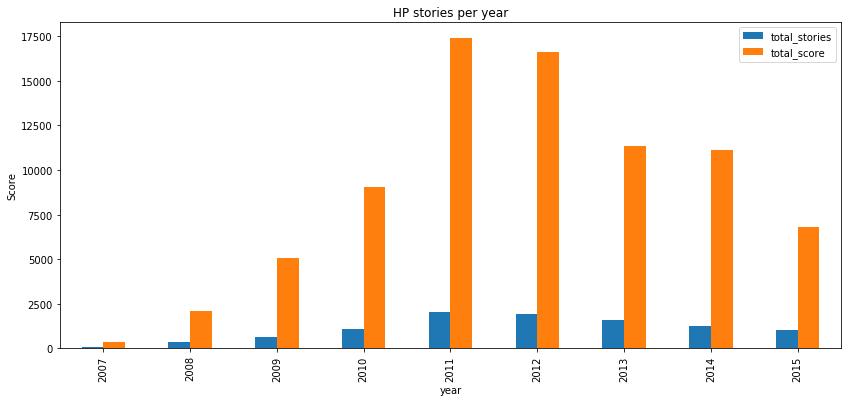

In [32]:
hp_stories_df = pd.DataFrame(data=[list(x.values()) for x in hp_stories_per_year], columns=list(hp_stories_per_year[0].keys()))
hp_stories_df.plot(x="year",y=["total_stories","total_score"],
                     kind="bar",figsize=(14,6),
                     title='HP stories per year').set_ylabel("Score")


In [33]:
query ="""
SELECT count(*) as total_stories, SUM(score) as total_score,
EXTRACT(YEAR FROM time_ts) AS year
FROM `bigquery-public-data.hacker_news.stories`
WHERE REGEXP_CONTAINS(title, r"(T|t)esla")
GROUP BY year
ORDER BY year
"""

hacker_news.estimate_query_size(query)

0.11040666233748198

In [34]:
query_job = client.query(query)
iterator = query_job.result(timeout=30)
tesla_stories_per_year = list(iterator)

Text(0, 0.5, 'Score')

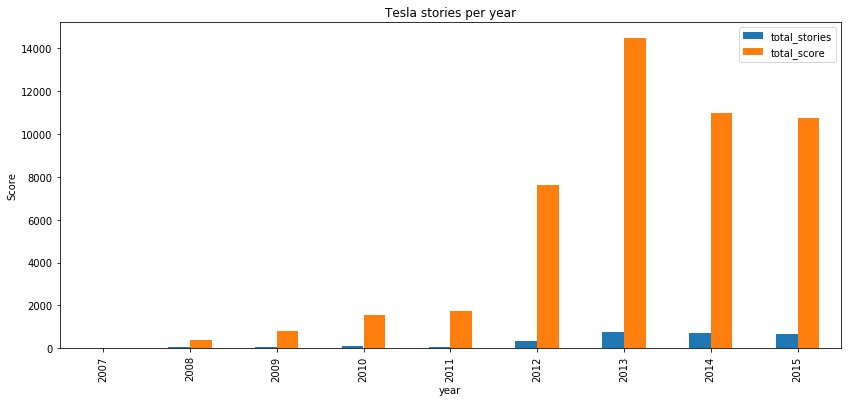

In [35]:
tesla_stories_df = pd.DataFrame(data=[list(x.values()) for x in tesla_stories_per_year], columns=list(tesla_stories_per_year[0].keys()))
tesla_stories_df.plot(x="year",y=["total_stories","total_score"],
                     kind="bar",figsize=(14,6),
                     title='Tesla stories per year').set_ylabel("Score")

In [36]:
query ="""
SELECT count(*) as total_stories, SUM(score) as total_score,
EXTRACT(YEAR FROM time_ts) AS year
FROM `bigquery-public-data.hacker_news.stories`
WHERE REGEXP_CONTAINS(title, r"(Y|y)ahoo")
GROUP BY year
ORDER BY year
"""

hacker_news.estimate_query_size(query)

0.11040666233748198

In [37]:
query_job = client.query(query)
iterator = query_job.result(timeout=30)
yahoo_stories_per_year = list(iterator)

Text(0, 0.5, 'Score')

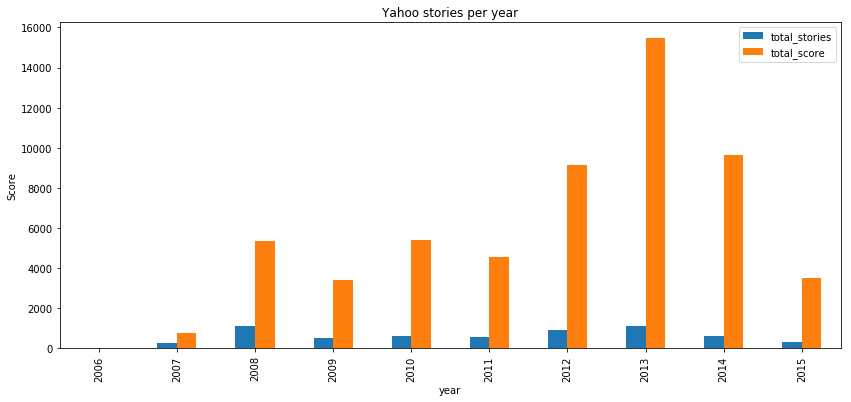

In [38]:
yahoo_stories_df = pd.DataFrame(data=[list(x.values()) for x in yahoo_stories_per_year], columns=list(yahoo_stories_per_year[0].keys()))
yahoo_stories_df.plot(x="year",y=["total_stories","total_score"],
                     kind="bar",figsize=(14,6),
                     title='Yahoo stories per year').set_ylabel("Score")

In [39]:
query ="""
SELECT count(*) as total_stories, SUM(score) as total_score,
EXTRACT(YEAR FROM time_ts) AS year
FROM `bigquery-public-data.hacker_news.stories`
WHERE REGEXP_CONTAINS(title, r"(F|f)acebook")
GROUP BY year
ORDER BY year
"""

hacker_news.estimate_query_size(query)

0.11040666233748198

In [40]:
query_job = client.query(query)
iterator = query_job.result(timeout=30)
fb_stories_per_year = list(iterator)

Text(0, 0.5, 'Score')

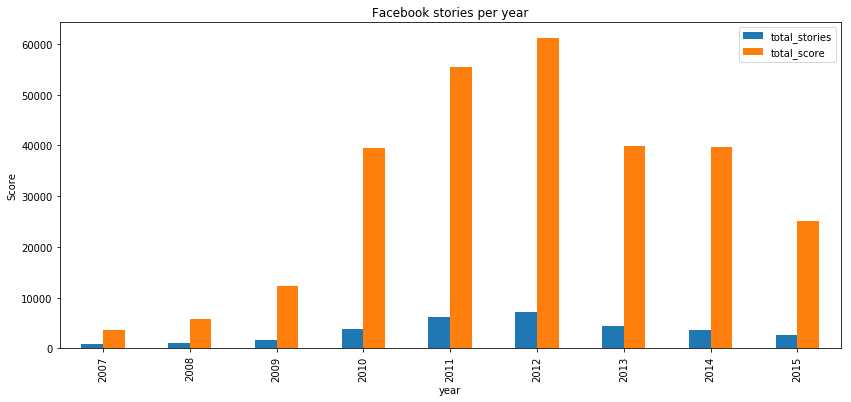

In [41]:
fb_stories_df = pd.DataFrame(data=[list(x.values()) for x in fb_stories_per_year], columns=list(fb_stories_per_year[0].keys()))
fb_stories_df.plot(x="year",y=["total_stories","total_score"],
                     kind="bar",figsize=(14,6),
                     title='Facebook stories per year').set_ylabel("Score")

Most of these companies are well estabalished companies now. I've intentionally included yahoo and HP here.  According to [Fortune](http://fortune.com/2013/05/06/20-companies-that-lost-the-most/) HP was of the least profitable company in year 2013. Yahoo was [once king of internet](https://www.forbes.com/sites/briansolomon/2016/07/25/yahoo-sells-to-verizon-for-5-billion-marissa-mayer/#69a42d12450f) which was sold for very low price in year 2016. One trend we can agree on successful companies like facebook has thousands of stories and are able to maintain score more than 10,000 per year.


# YC Exited VS Dead


Now its time to run our speculations and see if the exited and dead had some differences in story coverage and see if we can generalize.

YCombinator maintains a [list of companies](http://yclist.com/) of startups which we can use as a reference to get insights. This site contains Exited Active and Dead startups, this name gives indications if companies are bought by other companies or still supported by YC or dropped out of YC funding because of poor results. Now lets compare the score and stories of Dead and exited companies like Twitch.tv, Reddit, Zillabyte and Kicksend.

Out of these four companies Twitch was acquired by amazon in 2014 and Reddit was acquired by Conde Nast in 2006.
Twitch and Reddit are in YCombinator's Exit list and Kicksend and Zillabyte are in Failed list.

In [42]:
query ="""
SELECT count(*) as total_stories, SUM(score) as total_score,
EXTRACT(YEAR FROM time_ts) AS year
FROM `bigquery-public-data.hacker_news.stories`
WHERE REGEXP_CONTAINS(title, r"(T|t)witch.tv")
GROUP BY year
ORDER BY year
"""

hacker_news.estimate_query_size(query)

0.11040666233748198

In [43]:
query_job = client.query(query)
iterator = query_job.result(timeout=30)
twitch_stories_per_year = list(iterator)

Text(0, 0.5, 'Score')

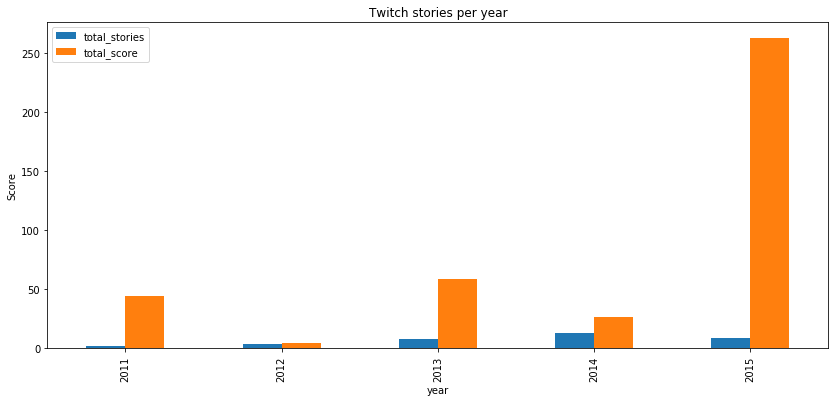

In [44]:
twitch_stories_df = pd.DataFrame(data=[list(x.values()) for x in twitch_stories_per_year], columns=list(twitch_stories_per_year[0].keys()))
twitch_stories_df.plot(x="year",y=["total_stories","total_score"],
                     kind="bar",figsize=(14,6),
                     title='Twitch stories per year').set_ylabel("Score")

In [45]:
query ="""
SELECT count(*) as total_stories, SUM(score) as total_score,
EXTRACT(YEAR FROM time_ts) AS year
FROM `bigquery-public-data.hacker_news.stories`
WHERE REGEXP_CONTAINS(title, r"(R|r)eddit")
GROUP BY year
ORDER BY year
"""

hacker_news.estimate_query_size(query)

0.11040666233748198

In [46]:
query_job = client.query(query)
iterator = query_job.result(timeout=30)
reddit_stories_per_year = list(iterator)

Text(0, 0.5, 'Score')

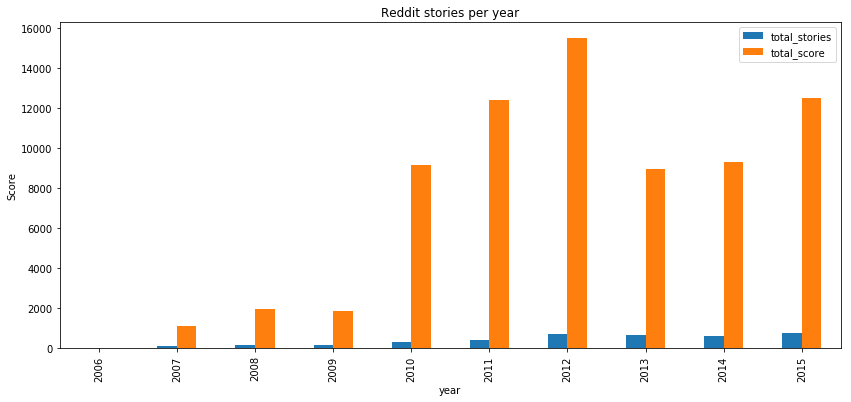

In [47]:
reddit_stories_df = pd.DataFrame(data=[list(x.values()) for x in reddit_stories_per_year], columns=list(reddit_stories_per_year[0].keys()))
reddit_stories_df.plot(x="year",y=["total_stories","total_score"],
                     kind="bar",figsize=(14,6),
                     title='Reddit stories per year').set_ylabel("Score")

In [48]:
query ="""
SELECT count(*) as total_stories, SUM(score) as total_score,
EXTRACT(YEAR FROM time_ts) AS year
FROM `bigquery-public-data.hacker_news.stories`
WHERE REGEXP_CONTAINS(title, r"(Z|z)illabyte")
GROUP BY year
ORDER BY year
"""

hacker_news.estimate_query_size(query)

0.11040666233748198

In [49]:
query_job = client.query(query)
iterator = query_job.result(timeout=30)
zillabyte_stories_per_year = list(iterator)

Text(0, 0.5, 'Score')

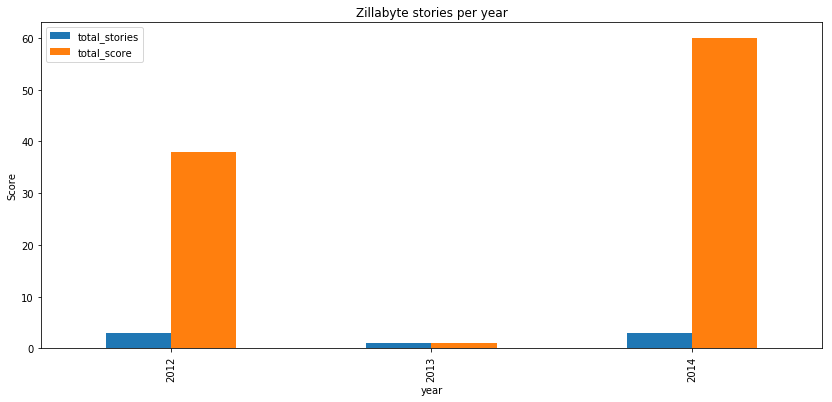

In [50]:
zillabyte_stories_df = pd.DataFrame(data=[list(x.values()) for x in zillabyte_stories_per_year], columns=list(zillabyte_stories_per_year[0].keys()))
zillabyte_stories_df.plot(x="year",y=["total_stories","total_score"],
                     kind="bar",figsize=(14,6),
                     title='Zillabyte stories per year').set_ylabel("Score")

In [51]:
query ="""
SELECT count(*) as total_stories, SUM(score) as total_score,
EXTRACT(YEAR FROM time_ts) AS year
FROM `bigquery-public-data.hacker_news.stories`
WHERE REGEXP_CONTAINS(title, r"(K|k)icksend")
GROUP BY year
ORDER BY year
"""

hacker_news.estimate_query_size(query)

0.11040666233748198

In [52]:
query_job = client.query(query)
iterator = query_job.result(timeout=30)
kicksend_stories_per_year = list(iterator)

Text(0, 0.5, 'Score')

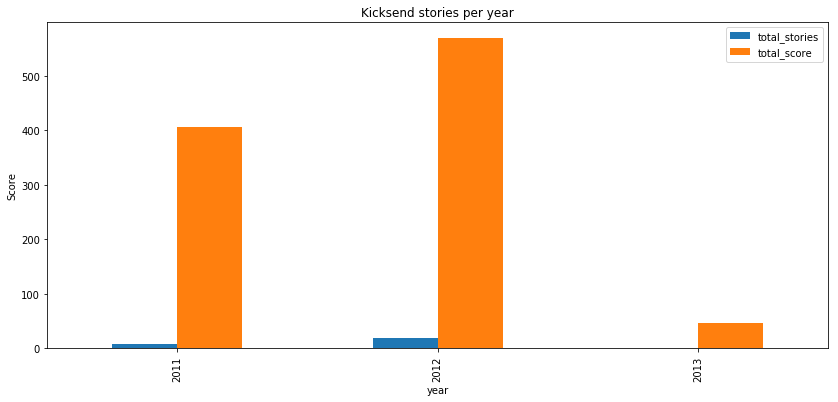

In [53]:
kicksend_stories_df = pd.DataFrame(data=[list(x.values()) for x in kicksend_stories_per_year], columns=list(kicksend_stories_per_year[0].keys()))
kicksend_stories_df.plot(x="year",y=["total_stories","total_score"],
                     kind="bar",figsize=(14,6),
                     title='Kicksend stories per year').set_ylabel("Score")

Reddit's graph has more than 10 thousand scores many consecutive years for almost same number of stories (for not much increase). Zillabyte was founded in 2011 and then relaunched in 2014 and you can see the data shows the similar trend with higher score value for almost same number of stories.

Kicksend on the other hand has less coverage in 2013 and after that no stories at all. As compared to Zillabyte its total score shows downward trend. One thing to note here both companies got funding (Kicksend 1 and Zillabyte 1.5 million) in seed round. 

By comparing these graphs one can definitely say amount of coverage by Hacker News is predictive of a startup’s success.

# Which YC companies are scoring more points?

In this section we will analize  some YC companies stories and see which one is getting more popular by time. This is direct indicator of how well are the companies doing. For comparison i am accessing names of active companies from [YClist](http://yclist.com/) website. Here i have selected only a few random names of active companies on [YClist](http://yclist.com/) with reasonable amount of stories to compare and analyse.


Now we will use that method I mentioned earlier to reduce the processed data by using single Regular expression for all the companies.

In [54]:
companies_list = ["scribd","weebly" ,"songkick","ninite", "startuply","airbnb"]

query ="""
SELECT title, score, time_ts
FROM `bigquery-public-data.hacker_news.stories`
WHERE REGEXP_CONTAINS(title, r"Scribd |Weebly |Songkick |Ninite |Startuply |AirBnb ") 
ORDER BY time_ts
"""
hacker_news.estimate_query_size(query)

0.11040666233748198

In [55]:
query_job = client.query(query)
iterator = query_job.result(timeout=30)
hn_ompanies = list(iterator)

In [56]:
print ("Total stories by all of these companies",len(hn_ompanies))

Total stories by all of these companies 288


Data processing is needed names of companies can be in capitals or small so we will convert all the string to small letters. Then we will create year column by accessing the datetime attribute `dt`, this can also be used to access date and month. (for more information visit this question on [stackoverflow](https://stackoverflow.com/questions/25146121/extracting-just-month-and-year-from-pandas-datetime-column-python))

In [57]:
companies_stories_df = pd.DataFrame(data=[list(x.values()) for x in hn_ompanies], columns=list(hn_ompanies[0].keys()))
companies_stories_df["title"] =companies_stories_df["title"].str.lower()

In [58]:
companies_stories_df['year'] = companies_stories_df['time_ts'].dt.year

Then we will loop through the list of companies and use `.str.contains` function of pandas Dataframe to access all the titles with company name.

Then we will group the dataframe by year and aggrigate score and find counts attribute. Pandas support these complex operations in order to manipulate the data structures. For more information about `agg` function you can visit [link](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.core.groupby.DataFrameGroupBy.agg.html)
After doing this we will directly call the plot function to see the plots of all the companies in `companies_list`. You can change the names of companies dont forget to update the regular expression in SQL query after.

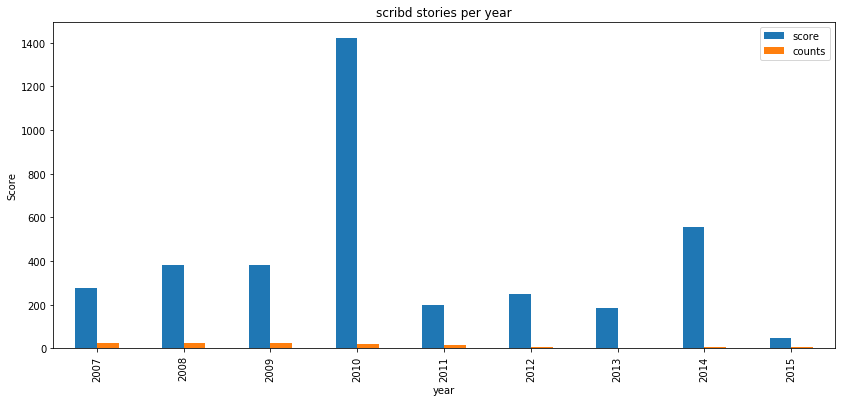

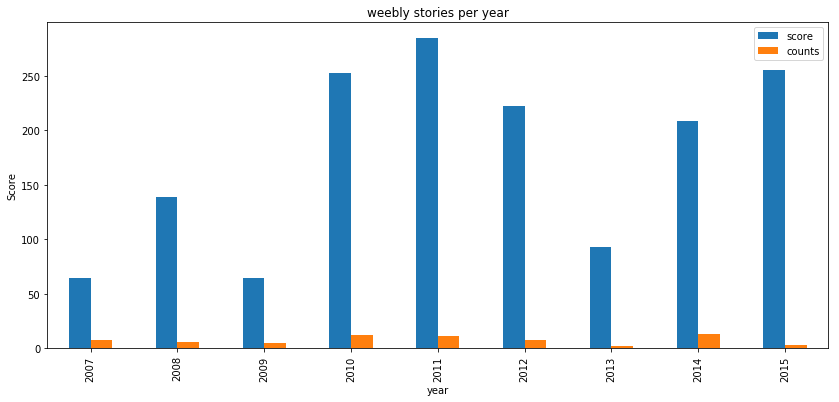

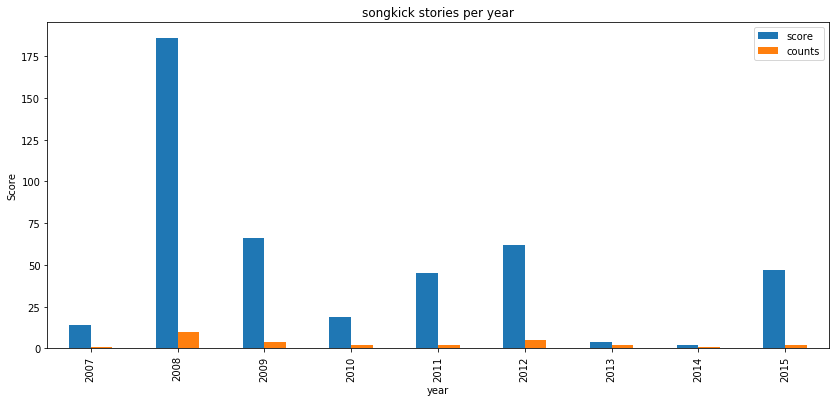

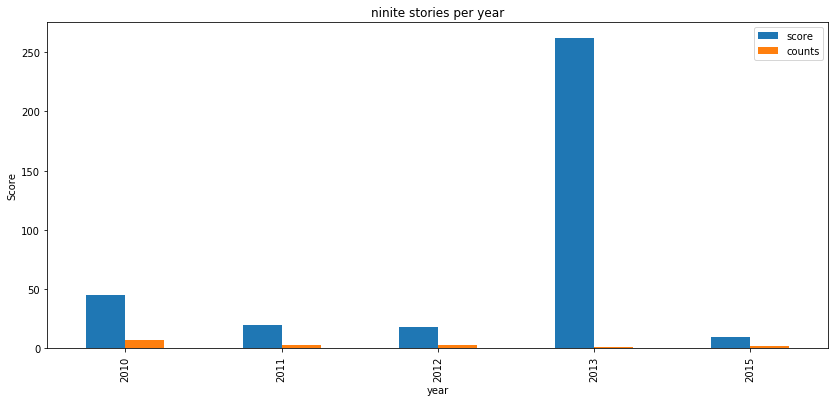

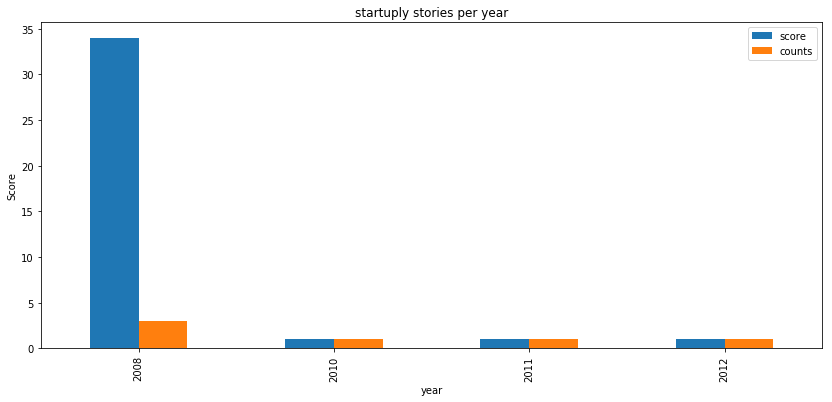

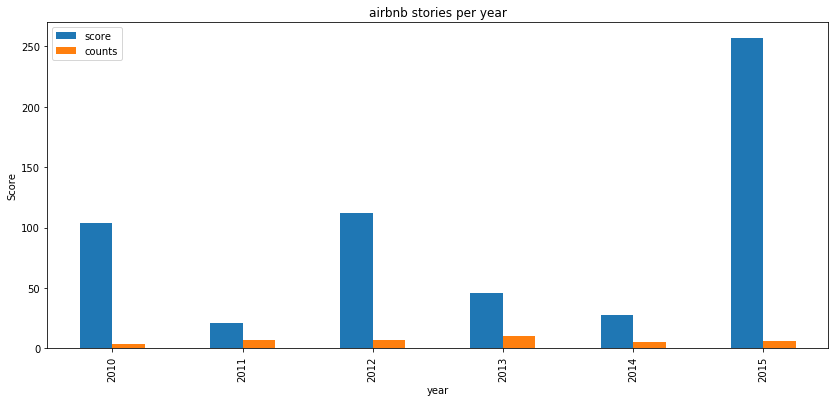

In [59]:
for company in companies_list:
    comp_df = companies_stories_df.loc[companies_stories_df["title"].str.contains(company)]
    if len(comp_df)>0 :
        agg_d = {'score':'sum'}
        comp_plot = comp_df.groupby(["year"], as_index=False).agg(agg_d)
        comp_plot["counts"] = comp_df.groupby(["year"], as_index=False).size().reset_index(name='counts').counts
        comp_plot.plot(x="year",y=["score","counts"],
                     kind="bar",figsize=(14,6),
                     title=company+' stories per year').set_ylabel("Score")
        plt.show()

All of  these companies are still active on [YClist](http://yclist.com/) website. From these plots we can see only few companies stories have been scored better comprared to each other. Scribd stories scored top position in year 2010 after that their scores were barely reaching 200. Airbnb stories scores has shown progress as compared to its previous years. Whereas Startuply's score has been low after year 2008.

# What is in Hacker News stories?


This section is for new commers to know what kind of content one can find on Hacker News. For that we will access top stories title and use Named entity detection to find what they are about. The main focus of this analysis is to see which topic company or people are most popular on Hacker news. 

First of all you should know SpaCy is an industry grade package used for various NLP. This package can handle many tasks commonly associated with building an end-to-end natural language processing pipeline:

1. Tokenization
1. Text normalization, such as lowercasing, stemming/lemmatization
1. Part-of-speech tagging
1. Syntactic dependency parsing
1. Sentence boundary detection
1. Named entity recognition and annotation

(If you want to see more examples of SpaCy please visit [this](https://www.kaggle.com/poonaml/bidirectional-lstm-spacy-on-yelp-reviews) kernel it covers NLP over Yelp data set.)

In our SQL query we have limited the data to 100 records but you can go ahead and change this value to do experiments.

In [60]:
query ="""
SELECT title
FROM `bigquery-public-data.hacker_news.stories`
ORDER BY score DESC
LIMIT 1000
"""
hacker_news.estimate_query_size(query)

0.09599658381193876

In [61]:
query_job = client.query(query)
iterator = query_job.result(timeout=30)
top_stories_hn = list(iterator)

In [62]:
top_stories_df = pd.DataFrame(data=[list(x.values()) for x in top_stories_hn], columns=list(top_stories_hn[0].keys()))
top_stories_df.head()

,title
0,Steve Jobs has passed away.
1,Show HN: This up votes itself
2,Tim Cook Speaks Up
3,2048
4,Don't Fly During Ramadan


Fun fact remember we calculated top stories in above cell and it had more than 4k score. The output above shows the head of table which is ordered in decreasing order of score. Well now you know tite of that post too.


In following cell we will use `apply` function to perform operation over all the rows of title column in pandas data frame we just defined above (for more information on apply function visit [link](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.apply.html)). This funcion takes in another function which process each element of column.`find_entity` we pass title `nlp` funtion which we defined in import section. this function returns parsed title and has `ents` attribute. And finally all the attributes are joined to form one string.

In [63]:
%%time

def find_entity(title):
    
    parsed_title = nlp(title)
    entity_arr = []
    for num, entity in enumerate(parsed_title.ents):
        entity_arr.append(entity.text)
    return  ' '.join(entity_arr)

top_stories_df["entity"]= top_stories_df["title"].apply(find_entity)


CPU times: user 11.4 s, sys: 0 ns, total: 11.4 s
Wall time: 11.4 s


In [64]:
top_stories_df = top_stories_df.loc[~ (top_stories_df['entity'] == "")]
top_stories_df.head()


,title,entity
0,Steve Jobs has passed away.,Steve Jobs
2,Tim Cook Speaks Up,Tim Cook Speaks
3,2048,2048
6,Microsoft takes .NET open source and cross-pla...,Microsoft
7,Watch a VC use my name to sell a con,VC


In [65]:
top_entities = top_stories_df.groupby(["entity"]).size().reset_index(name='counts')
top_entities_p =top_entities.sort_values(['counts'])[::-1][:15]

Text(0, 0.5, 'counts')

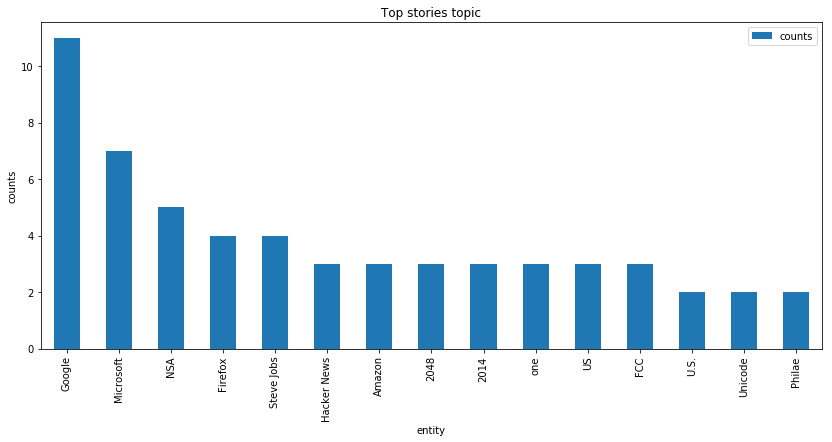

In [66]:
top_entities_p.plot(x="entity",y=["counts"],
                     kind="bar",figsize=(14,6),
                     title='Top stories topic').set_ylabel("counts")

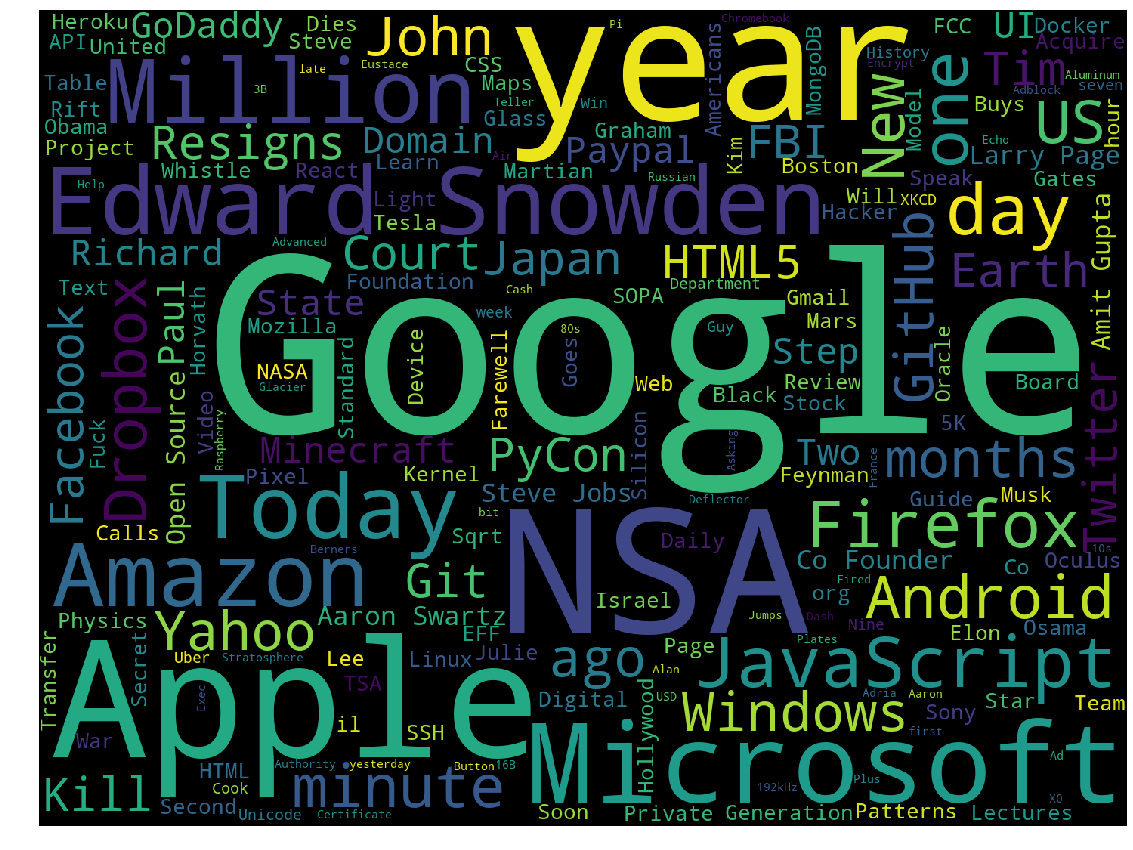

In [67]:
cloud = WordCloud(width=1440, height= 1080,max_words= 200).generate(' '.join(top_entities.entity.values))
plt.figure(figsize=(20, 15))
plt.imshow(cloud)
plt.axis('off');
plt.show()

So we can see here Hacker news is all about technical stories about tech companies and peope like Steve jobs and Edward Snowden.

 If you have any suggestions please commend down below.
 